In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from tqdm import tqdm

from helper import *

In [19]:
numeric_df = pd.read_csv('../new_data/clean_train_numeric.csv')
numeric_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [20]:
categoric_df = pd.read_csv('../new_data/clean_train_categoric.csv')
categoric_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,False,False,True,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,1
1,False,False,True,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,2
2,False,False,True,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,3
3,False,False,True,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,4
4,False,False,True,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,5


In [21]:
merged_df = pd.merge(numeric_df, categoric_df, on='Id', how='inner')
merged_df.to_csv('../new_data/clean_train_merged.csv', index=False)
merged_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,False,True,False,False,False,True,False


In [22]:
count_nulls(merged_df)

,nulls,percent_missing


In [23]:
X = merged_df.drop('SalePrice', axis=1)
y = merged_df['SalePrice']

param_grids = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForestRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]},
    'AdaBoostRegressor': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'BaggingRegressor': {'n_estimators': [10, 50, 100]},
    'ExtraTreesRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'DecisionTreeRegressor': {'max_depth': [None, 10, 20]},
    'KNeighborsRegressor': {'n_neighbors': [3, 5, 10]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
}

Total explained variance with selected components: 1.0000
Number of components selected: 30
Training models with PCA-transformed features...


100%|██████████| 11/11 [01:48<00:00,  9.88s/it]


Model Performance with PCA (RMSE):
Ridge: 43658.3135
Lasso: 43839.2318
ElasticNet: 43663.7821
RandomForestRegressor: 40154.0301
GradientBoostingRegressor: 39266.0030
AdaBoostRegressor: 45283.4690
BaggingRegressor: 40536.0838
ExtraTreesRegressor: 38517.6997
DecisionTreeRegressor: 52723.5301
KNeighborsRegressor: 50543.9156
SVR: 44445.1369

Best Model with PCA:
ExtraTreesRegressor(): 38517.6997
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


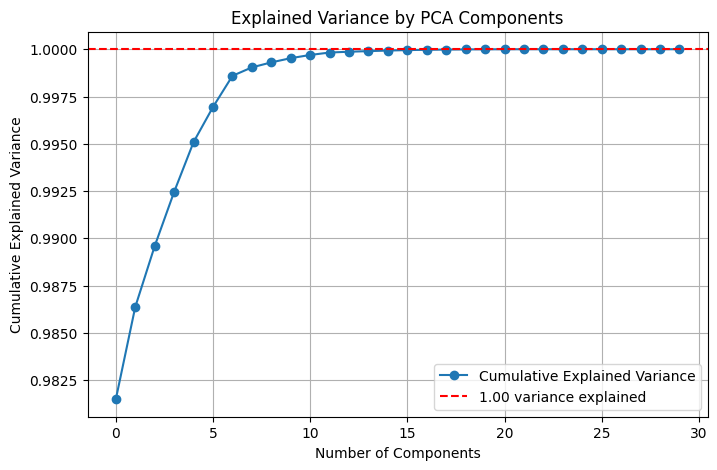



MSE: 32362.332641847403
R2 Score: 0.8061088365404906


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA(n_components=30)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Total explained variance with selected components: {explained_variance[-1]:.4f}")
print(f"Number of components selected: {pca.n_components_}")

results_pca = {}
best_models_pca = {}

print('Training models with PCA-transformed features...')
for name, model in tqdm(models.items()):
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = np.sqrt(-grid_search.best_score_) # RMSE

    results_pca[name] = best_rmse
    best_models_pca[name] = best_model

print('\nModel Performance with PCA (RMSE):')
for name, rmse in results_pca.items():
    print(f'{name}: {rmse:.4f}')

print('\nBest Model with PCA:')
best_model_pca = best_models_pca[min(results_pca, key=results_pca.get)]
print(f'{best_model_pca}: {results_pca[min(results_pca, key=results_pca.get)]:.4f}')

print(best_model_pca.get_params())

# Visualize explained variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o', label="Cumulative Explained Variance")
plt.axhline(y=explained_variance[-1], color='r', linestyle='--',label=f"{explained_variance[-1]:.2f} variance explained")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.legend()
plt.grid()
plt.show()

#MSE
y_pred = best_model_pca.predict(X_test_pca)
rmse = root_mean_squared_error(y_test, y_pred)
print('\n')
print(f'MSE: {rmse}')

r2_score = best_model_pca.score(X_test_pca, y_test)
print(f'R2 Score: {r2_score}')

## SFS

In [27]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_sfs = {}
best_models_sfs = {}

print("Training models with SFS-selected features...")

# Iterate through each model and parameter grid
for name, model in tqdm(models.items()):
    # Use SFS for feature selection
    sfs = SequentialFeatureSelector(
        model,
        n_features_to_select="auto",  # Auto determines the optimal number of features
        direction="forward",
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1
    )
    sfs.fit(X_train, y_train)
    
    # Transform data based on selected features
    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_sfs, y_train)
    
    # Evaluate the best model
    best_model = grid_search.best_estimator_
    best_rmse = np.sqrt(-grid_search.best_score_)  # RMSE

    results_sfs[name] = best_rmse
    best_models_sfs[name] = best_model

# Display model performance
print("\nModel Performance with SFS (RMSE):")
for name, rmse in results_sfs.items():
    print(f"{name}: {rmse:.4f}")

# Identify the best model
best_model_sfs = best_models_sfs[min(results_sfs, key=results_sfs.get)]
print("\nBest Model with SFS:")
print(f"{best_model_sfs}: {results_sfs[min(results_sfs, key=results_sfs.get)]:.4f}")
print(best_model_sfs.get_params())

# Test the best model
X_train_sfs = SequentialFeatureSelector(best_model_sfs, n_features_to_select="auto", direction="forward", scoring="neg_mean_squared_error", cv=5, n_jobs=-1).fit_transform(X_train, y_train)
X_test_sfs = SequentialFeatureSelector(best_model_sfs, n_features_to_select="auto", direction="forward", scoring="neg_mean_squared_error", cv=5, n_jobs=-1).transform(X_test)

y_pred = best_model_sfs.predict(X_test_sfs)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nTest Performance")
print(f"RMSE: {rmse:.4f}")

# R² Score
r2_score = best_model_sfs.score(X_test_sfs, y_test)
print(f"R² Score: {r2_score:.4f}")


Training models with SFS-selected features...


  0%|          | 0/11 [00:00<?, ?it/s]/home/alexj/code/House-Price-Prediction/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alexj/code/House-Price-Prediction/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexj/code/House-Price-Prediction/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/alexj/code/House-Price-Prediction/.venv/

KeyboardInterrupt: 

## Optuna

In [ ]:
""" import optuna
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np

# Data Preparation
X = merged_df.drop('SalePrice', axis=1)
y = merged_df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models and corresponding parameter grids
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5)),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
    'PolynomialPipeline': Pipeline([
        ('poly', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('regressor', Ridge()),
    ]),
}

param_grids = {
    'Ridge': {
        'alpha': (0.01, 100.0, 'log-uniform'),
    },
    'Lasso': {
        'alpha': (0.001, 10.0, 'log-uniform'),
    },
    'ElasticNet': {
        'alpha': (0.001, 10.0, 'log-uniform'),
        'l1_ratio': (0.1, 0.9),
    },
    'RandomForestRegressor': {
        'n_estimators': (100, 300),
        'max_depth': (5, 30),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
    },
    'GradientBoostingRegressor': {
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'n_estimators': (100, 300),
        'max_depth': (3, 10),
        'subsample': (0.7, 1.0),
    },
    'AdaBoostRegressor': {
        'n_estimators': (50, 200),
        'learning_rate': (0.01, 1.0, 'log-uniform'),
    },
    'ExtraTreesRegressor': {
        'n_estimators': (100, 300),
        'max_depth': (5, 30),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
    },
    'DecisionTreeRegressor': {
        'max_depth': (5, 30),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
    },
    'KNeighborsRegressor': {
        'n_neighbors': (3, 15),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    },
    'SVR': {
        'C': (0.1, 100.0, 'log-uniform'),
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    },
    'PolynomialPipeline': {
        'poly__degree': (2, 3),
        'regressor__alpha': (0.01, 10.0, 'log-uniform'),
    },
}

# Function to apply SFS and run Bayesian Optimization
def run_model_selection(model_name, model, param_grid):
    # Apply SFS
    sfs = SequentialFeatureSelector(
        model,
        n_features_to_select='auto',
        direction='forward',
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    sfs.fit(X_train, y_train)

    # Transform data based on selected features
    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)

    # Define Optuna objective function
    def objective(trial):
        params = {}
        for param, grid in param_grid.items():
            if isinstance(grid, tuple) and len(grid) == 3 and grid[2] == 'log-uniform':
                params[param] = trial.suggest_float(param, grid[0], grid[1], log=True)
            elif isinstance(grid, tuple) and len(grid) == 2:
                params[param] = trial.suggest_int(param, grid[0], grid[1])
            elif isinstance(grid, list):
                params[param] = trial.suggest_categorical(param, grid)

        # Train model with suggested parameters
        model.set_params(**params)
        neg_mse = cross_val_score(model, X_train_sfs, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        return -1 * np.mean(neg_mse)

    # Run Bayesian Optimization
    study = optuna.create_study(direction='minimize', study_name=f"{model_name} Optimization")
    study.optimize(objective, n_trials=50, n_jobs=-1)

    # Train final model on selected features with best parameters
    best_params = study.best_params
    model.set_params(**best_params)
    model.fit(X_train_sfs, y_train)

    # Evaluate on test set
    y_pred = model.predict(X_test_sfs)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        'model': model_name,
        'rmse': rmse,
        'r2': r2,
        'best_params': best_params,
    }

# Run optimization for all models
results = []
for model_name, model in tqdm(models.items()):
    if model_name in param_grids:
        print(f"Optimizing {model_name}...")
        result = run_model_selection(model_name, model, param_grids[model_name])
        results.append(result)

# Display results
results = sorted(results, key=lambda x: x['rmse'])
for res in results:
    print(f"Model: {res['model']}, RMSE: {res['rmse']:.4f}, R²: {res['r2']:.4f}")
    print(f"Best Params: {res['best_params']}")
 """

  0%|          | 0/11 [00:00<?, ?it/s]

Optimizing Ridge...


  0%|          | 0/11 [03:04<?, ?it/s]


KeyboardInterrupt: 